## Welcome to Time Series Forecasting for Finance! (Part 1)

**Hint: This notebook uses minimal ML.** 

See how **data processing** and **basic math** are the real cornerstones of financial forecasting.

Starting with the steps:

- Data cleaning
- Tick to Bar Conversion

Ensuring the dataset is consistent and relevant to today's market

In [47]:
import warnings
warnings.filterwarnings(action='ignore')

from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from joblib import parallel_backend

import sys
sys.path.append('../utils/')
from preprocess import tick_to_dollar_bar, clean_and_filter_data
from primary_model import generate_cusum_events, triple_barrier_method, generate_trading_signals_ma

First, to load the data and to check for proper formatting.

In [48]:
ohlcv_data = pd.read_csv("../datasets/hbar_data.csv", parse_dates=['datetime'])
# Keep only the datetime, close, and volume columns
ohlcv_data.head()

,datetime,close,volume
0,2020-05-15 06:01:00,0.0378,25222.0
1,2020-05-15 06:02:00,0.0378,6531.0
2,2020-05-15 06:03:00,0.0379,17315.1
3,2020-05-15 06:04:00,0.0379,0.0
4,2020-05-15 06:05:00,0.0381,13543.5


The columns consist of:  datetime, close, and volume. 

Traditional stock market and cryptocurrency datasets also includes the open, high and low prices

For the sake of this tutorial, close suffices.

Now to visualize the price action and ideate how we should process the data.

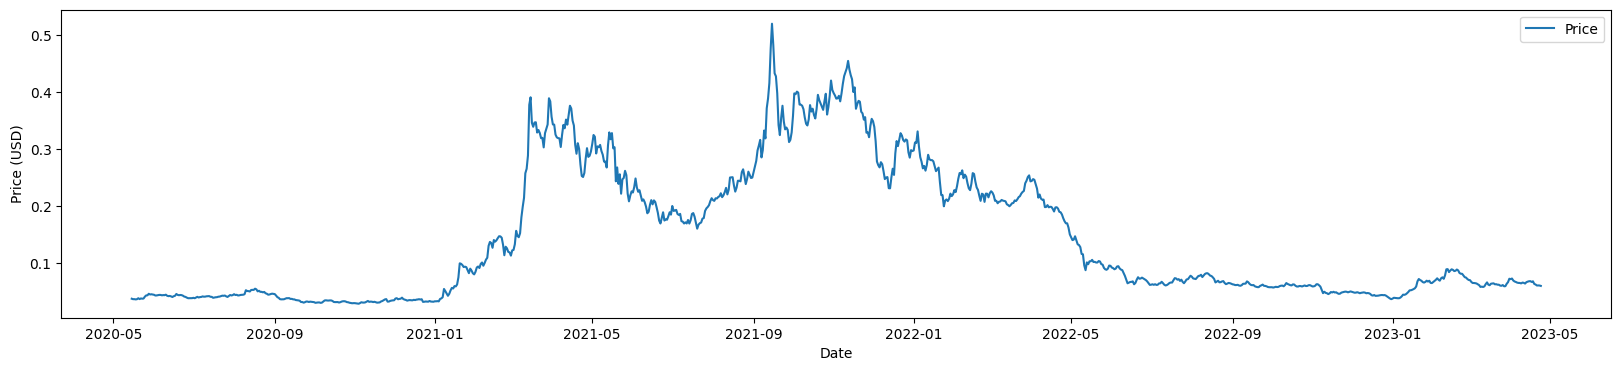

In [49]:
# Resample the data to daily frequency
ohlcv_data_daily = ohlcv_data.resample('D', on='datetime').agg({'close': 'mean', 'volume': 'sum'}).reset_index()

# Create a plot with two y-axes
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 4)

# Plot the 'close' column in the original data
sns.lineplot(x=ohlcv_data_daily['datetime'], y=ohlcv_data_daily['close'], ax=ax1, label='Price')
ax1.set_ylabel('Price (USD)')
ax1.set_xlabel('Date')


# Display the plot
plt.show()

It looks like January 2021-June 2022 was an abnormally volatile time.

The market has settled down considerably since then. 

The volatile period is abnormal compared to today's market, so it's best to remove it.

In [50]:
ohlcv_data_cleaned = clean_and_filter_data(ohlcv_data, ['2021-01-01', '2022-06-01'])
ohlcv_data_cleaned_daily = ohlcv_data_cleaned.resample('D', on='datetime').agg({'close': 'mean', 'volume': 'sum'}).reset_index()

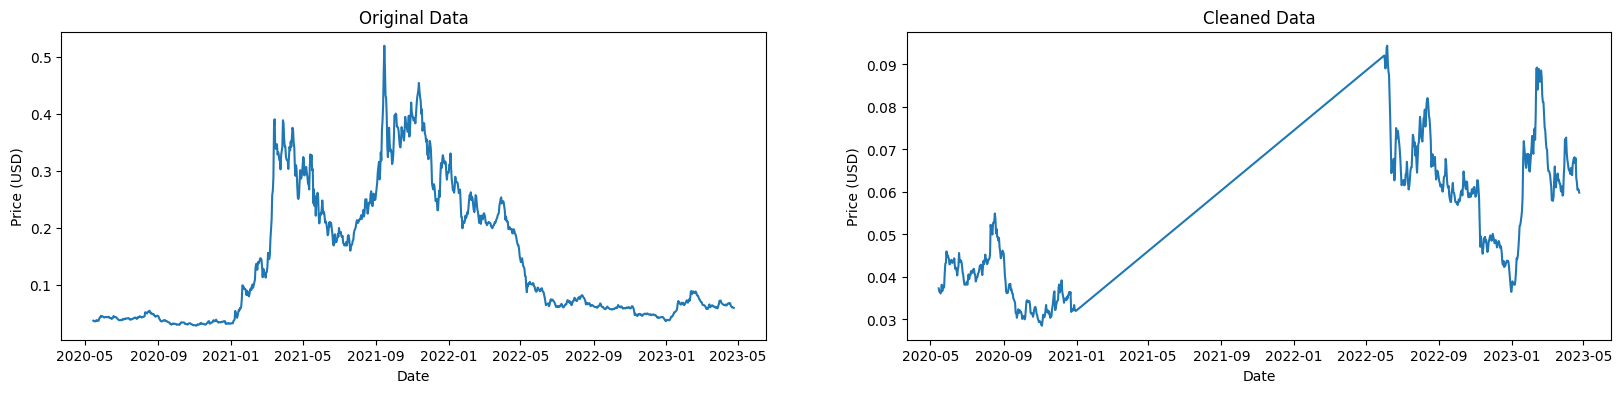

In [51]:
# Set the figure size
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Plot the 'close' column in the original data using Seaborn
sns.lineplot(ax=axes[0], x=ohlcv_data_daily['datetime'], y=ohlcv_data_daily['close'])
axes[0].set(title='Original Data', xlabel='Date', ylabel='Price (USD)')

# Plot the 'close' column in the cleaned data using Seaborn
sns.lineplot(ax=axes[1], x=ohlcv_data_cleaned_daily['datetime'], y=ohlcv_data_cleaned_daily['close'])
axes[1].set(title='Cleaned Data', xlabel='Date', ylabel='Price (USD)')

# Display the plot
plt.show()

The cleaned data displays relatively consistent price action, providing a solid starting point for data transformations.

**Tick Data transformation into Bar Data:** Tick data can be unreliable, as it doesn't take trade volume into account. In contrast, *bar data* is more reliable due to its consideration of trade volume.

**Types of Bar Data:** There are various types of bar data, including:

- *Volume bars*
- *Dollar bars*
- *Run bars*
- *Imbalance bars*

For simplicity, we will focus on **dollar bars** in this analysis. I used 50 bars per day because of its desirable statistical attributes.

In [52]:
bars_per_day=50
dollar_bars = tick_to_dollar_bar(ohlcv_data_cleaned, bars_per_day=bars_per_day)

In [53]:
print('Tick data consist of {} timepoints with a volume average of {:.0f} and volume std of {:.0f}'.format(len(ohlcv_data), ohlcv_data.volume.mean(), ohlcv_data.volume.std()))
print('Dollar bars consist of {} timepoints with a volume average of {:.0f} and volume std of {:.0f}'.format(len(dollar_bars),(dollar_bars.volume*dollar_bars.close).mean(),(dollar_bars.volume*dollar_bars.close).std()))

Tick data consist of 1545205 timepoints with a volume average of 12252 and volume std of 61450
Dollar bars consist of 30132 timepoints with a volume average of 11676 and volume std of 16271




As you can see, dollar bars are far less variable than standard tick data.

With this understanding of the advantages of using dollar bars over tick data, let's proceed to build our primary model.

### Primary Model Building

For primary model building, it is helpful to focus on simple methods like:

- Moving averages
- Trade Event Detection
- Triple Barrier Method
- Hyperparameter Optimization




**Why Rolling Averages?**

 The `generate_trading_signals_ma` method generates trading signals based on the relationship between two moving averages (MA):

- *Fast MA*
- *Slow MA*

In [54]:
slow_window=50
fast_window=10
dollar_bars = generate_trading_signals_ma(dollar_bars, slow_window, fast_window)
dollar_bars.head()

,datetime,open,high,low,close,volume,fast_ma,slow_ma,side
49,2020-05-20 06:58:00,0.0390,0.0390,0.0380,0.0381,179616.1,0.037326,0.03702,1
50,2020-05-20 07:47:00,0.0381,0.0413,0.0381,0.0390,163540.8,0.037330,0.03726,1
51,2020-05-20 09:03:00,0.0390,0.0390,0.0361,0.0365,189844.7,0.037244,0.03733,-1
52,2020-05-20 11:42:00,0.0365,0.0385,0.0365,0.0384,192714.2,0.037212,0.03758,-1
53,2020-05-20 15:47:00,0.0384,0.0399,0.0378,0.0390,170574.1,0.037216,0.03782,-1


By comparing the fast and slow moving averages, we approximate whether or not we should buy or sell at each timepoint.

- If the *fast MA* is greater than the *slow MA*, the `side` column is set to **1**, indicating a *buy signal*.
- If the *fast MA* is less than the *slow MA*, the `side` column is set to **-1**, indicating a *sell signal*.

This approximates which side to bet on for **every time point.**


**Risk Management: Focus on Key Timepoints**

Do not bet on *every* dollar bar, as that's too risky. Instead, it's better to place larger bets on fewer, more certain timepoints. This is where **events** come into play 🎯.

Various mathematical formulae can be used to create events. For this tutorial, we are using the **CUSUM** (Cumulative Sum) method, which is recommended by _Marcos López de Prado_. 

> 🌟 **CUSUM** helps us identify timepoints with big shifts in the average price, enabling us to focus our bets on these critical moments.


In [55]:
threshold = 0.0555 # Determines sensitivity. A higher threshold leads to less events
trading_events = generate_cusum_events(dollar_bars, threshold)
trading_events = pd.merge(trading_events, dollar_bars[['datetime', 'close']], on='datetime', how='left')

Now that we have extracted event timepoints and the sides to bet on, we can see our primary model take shape.
**Time to visualize it..**

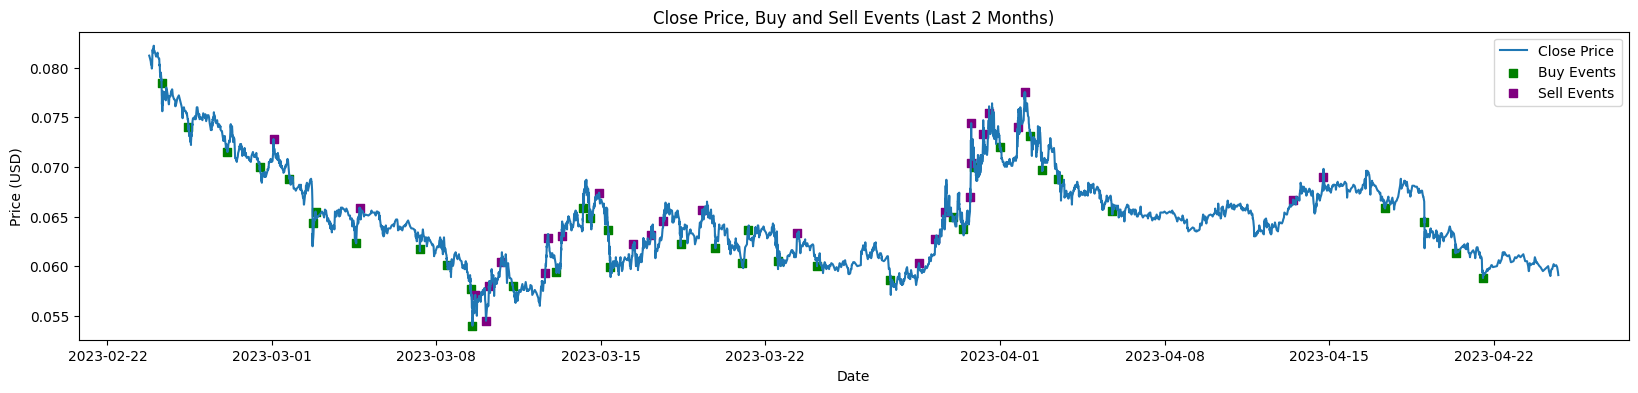

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the timestamp for 2 months prior to the last available data point
last_timestamp = dollar_bars['datetime'].max()
two_months_ago = last_timestamp - timedelta(days=60)

# Filter dollar_bars and trading_events_close for data from the last 2 months
dollar_bars_last_2_months = dollar_bars[dollar_bars['datetime'] > two_months_ago]
trading_events_close_last_2_months = trading_events[trading_events['datetime'] > two_months_ago]

# Create a line plot with the 'close' column in dollar_bars_last_2_months
fig, ax = plt.subplots(figsize=(20, 4))
sns.lineplot(ax=ax, x=dollar_bars_last_2_months['datetime'], y=dollar_bars_last_2_months['close'], label='Close Price')

# Add the buy events as green squares on the plot
buy_events = trading_events_close_last_2_months[trading_events_close_last_2_months['side'] == 1]
ax.scatter(buy_events['datetime'], buy_events['close'], marker='s', s=30, color='green', label='Buy Events')

# Add the sell events as violet squares on the plot
sell_events = trading_events_close_last_2_months[trading_events_close_last_2_months['side'] == -1]
ax.scatter(sell_events['datetime'], sell_events['close'], marker='s', s=30, color='purple', label='Sell Events')

# Update layout
ax.set(title='Close Price, Buy and Sell Events (Last 2 Months)', xlabel='Date', ylabel='Price (USD)')
ax.legend()

# Display the plot
plt.show()

The graph is helpful to validate our work so far.

We are generally seeing the the price rise after buy events, and fall after sell events. 

(It's not perfect but it's serviceable)

After an event is triggered, we must consider 3 possible exits for the trade strategy.

**Introducing the Triple Barrier Method**

The Triple Barrier Method is an effective way to manage the exit strategy of our trading algorithm. 

It helps determine when to close a trade by considering three barriers: Profit Taking, Stop Loss, and Time. 

By using the Triple Barrier Method, we can effectively manage our trades, ensuring that we exit them at the most appropriate time, either to secure profits or to minimize losses.



In [57]:
pt = 0.04 #the gain at which to take profit
sl = 0.06 # the loss at which to cut losses
min_ret = 0.01 # the minimum return to be considered for triple barrier labeling
num_days = 1 # the maximum time for a trade to be live
triple_barrier_labels = triple_barrier_method(dollar_bars, trading_events, pt, sl, min_ret, num_days)
triple_barrier_labels.head()

,datetime,type,return,t1,side,initial_price,final_price
0,2020-05-20 09:03:00,sl,-0.068493,2020-05-20 15:47:00,-1.0,0.0365,0.0390
1,2020-05-20 15:47:00,pt,0.046154,2020-05-20 21:43:00,-1.0,0.0390,0.0372
2,2020-05-21 04:18:00,pt,0.063452,2020-05-21 08:13:00,-1.0,0.0394,0.0369
3,2020-05-21 08:13:00,vb,-0.029810,2020-05-22 10:05:00,-1.0,0.0369,0.0380
4,2020-05-22 11:36:00,vb,0.046512,2020-05-23 14:07:00,-1.0,0.0387,0.0369


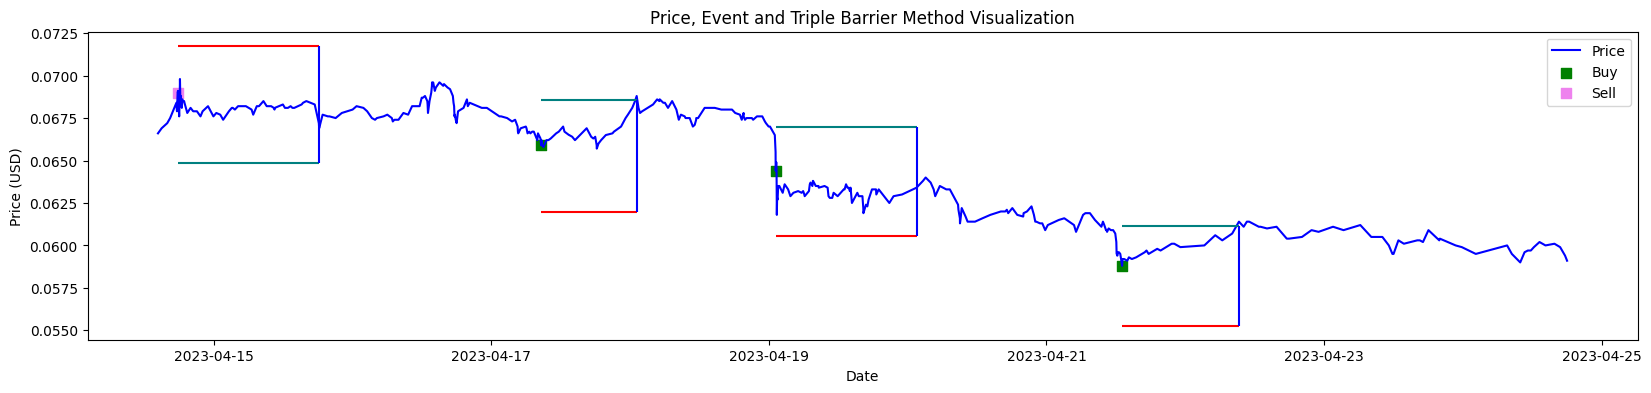

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter dollar_bars and triple_barrier_labels to only include the last two months
start_date = pd.Timestamp.now() - pd.DateOffset(weeks=3)
filtered_dollar_bars = dollar_bars[dollar_bars['datetime'] >= start_date]
filtered_triple_barrier_labels = triple_barrier_labels[triple_barrier_labels['datetime'] >= start_date]

buy_events = filtered_triple_barrier_labels[filtered_triple_barrier_labels['side'] == 1]
sell_events = filtered_triple_barrier_labels[filtered_triple_barrier_labels['side'] == -1]

fig, ax = plt.subplots(figsize=(20, 4))

# Plot the 'close' column in dollar_bars
sns.lineplot(ax=ax, x=filtered_dollar_bars['datetime'], y=filtered_dollar_bars['close'], label='Price', color='blue')

# Plot the trading events
ax.scatter(buy_events['datetime'], buy_events['initial_price'], marker='s', s=50, color='green', label='Buy')
ax.scatter(sell_events['datetime'], sell_events['initial_price'], marker='s', s=50, color='violet', label='Sell')

# Plot the triple barriers
for _, row in filtered_triple_barrier_labels.iterrows():
    ax.hlines(row['initial_price'] * (1 + (pt if row['side'] == 1 else -sl)), row['datetime'], row['t1'], colors='teal')
    ax.hlines(row['initial_price'] * (1 - (sl if row['side'] == 1 else -pt)), row['datetime'], row['t1'], colors='red')
    ax.vlines(row['t1'], row['initial_price'] * (1 - sl), row['initial_price'] * (1 + pt), colors='blue')

# Update layout
ax.set(title='Price, Event and Triple Barrier Method Visualization', xlabel='Date', ylabel='Price (USD)')
ax.legend()

# Display the plot
plt.show()


Here is a visual for the Triple Barrier Method applied to our trading events. 

The blue line represents the price, green squares indicate buy events, and violet squares indicate sell events.

The three barrier labels:

1. **Profit Taking (Teal Line):** This horizontal line represents the target price level for taking profits. If the price reaches this level, the position is closed with a profit.
2. **Stop Loss (Red Line):** This horizontal line represents the maximum tolerable loss. If the price reaches this level, the position is closed to prevent further losses.
3. **Time Barrier (Blue Line):** This vertical line represents the maximum duration for a trade to be active. If the price hasn't reached the profit taking or stop loss levels within this time frame, the position is closed.

## Congratulations!

You have successfully created a primary model for financial forcasting. 

With just data processing and basic math!

Along the way, you might have noticed that the primary model is dependent on several parameters.

In [59]:
# Global variables -- emperically set
EVENT_TRESHOLD = 0.0555
BARS_PER_DAY = 50
MIN_RET = 0.005

Manually tuning these parameters can be time-consuming and challenging.

**Good thing** you can leverage a hyperparameter optimization library to find the best results and save time.

In the following cell, we search for the best primary model parameters by maximizing the % return and accuracy of all trades

In [60]:
#search settings
n_random_trials = 120
n_total_trials = 200
n_jobs = 8  # Set the number of max parallel jobs according to # of available CPU cores

In [61]:
def objective(trial):
    # Choose hyperparameters from trial object
    slow_window = trial.suggest_int("slow_window", 30, 200)
    fast_window = trial.suggest_int("fast_window", 5, 50)
    pt = trial.suggest_float("pt", 0.04, 0.1)
    sl = trial.suggest_float("sl", 0.03, 0.2)
    num_days = trial.suggest_float("num_days", 0.5, 2.5)


    ohlcv_data = pd.read_csv("../datasets/hbar_data.csv", parse_dates=['datetime'])
    ohlcv_data_cleaned = clean_and_filter_data(ohlcv_data, ['2021-01-01', '2022-06-01'])
    dollar_bars = tick_to_dollar_bar(ohlcv_data_cleaned, bars_per_day=BARS_PER_DAY)
    
    dollar_bars = generate_trading_signals_ma(dollar_bars, slow_window, fast_window)

    trading_events = generate_cusum_events(dollar_bars, threshold=EVENT_TRESHOLD)
    triple_barrier_labels = triple_barrier_method(dollar_bars, trading_events, pt, sl, MIN_RET, num_days)
    total_ret = triple_barrier_labels['return'].sum()
    last_weeks = triple_barrier_labels['datetime'].iloc[-1] - pd.DateOffset(weeks=9)
    dollar_bars_last_weeks = triple_barrier_labels[triple_barrier_labels['datetime'] > last_weeks]
    
    recency_bias = dollar_bars_last_weeks['return'].sum()

    accuracy_multiplier = (triple_barrier_labels['return'].gt(0).mean() - 0.5)
    score = (total_ret + recency_bias) * accuracy_multiplier

    return score

# Create an Optuna study and optimize the hyperparameters
optuna.logging.set_verbosity(optuna.logging.WARNING) #don't show output of every trial
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(n_startup_trials=n_random_trials)
)

with parallel_backend("threading", n_jobs=n_jobs):
    study.optimize(objective, n_trials=n_total_trials, n_jobs=n_jobs)


The results are in:

In [62]:
# Print the best hyperparameters
print("\nBest trial:")
trial = study.best_trial
print("Score: {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))


Best trial:
Score: 1.4321014350508843
Params: 
slow_window: 185
fast_window: 7
pt: 0.04358402127690831
sl: 0.1814313049784803
num_days: 1.5623138787180055


Now to recreate the primary model with the best parameters.

In [63]:
# Get the best parameters from the study
best_params = study.best_params

# Extract the best parameters
slow_window = best_params["slow_window"]
fast_window = best_params["fast_window"]
pt = best_params["pt"]
sl = best_params["sl"]
num_days = best_params["num_days"]


ohlcv_data = pd.read_csv("../datasets/hbar_data.csv", parse_dates=['datetime'])
ohlcv_data_cleaned = clean_and_filter_data(ohlcv_data, ['2021-01-01', '2022-06-01'])
dollar_bars = tick_to_dollar_bar(ohlcv_data_cleaned, bars_per_day=BARS_PER_DAY)
dollar_bars = generate_trading_signals_ma(dollar_bars, slow_window, fast_window)

trading_events = generate_cusum_events(dollar_bars, threshold=EVENT_TRESHOLD)
triple_barrier_labels = triple_barrier_method(dollar_bars, trading_events, pt, sl, MIN_RET, num_days)
total_ret = triple_barrier_labels['return'].sum()


And visualize trades from the last 5 weeks!

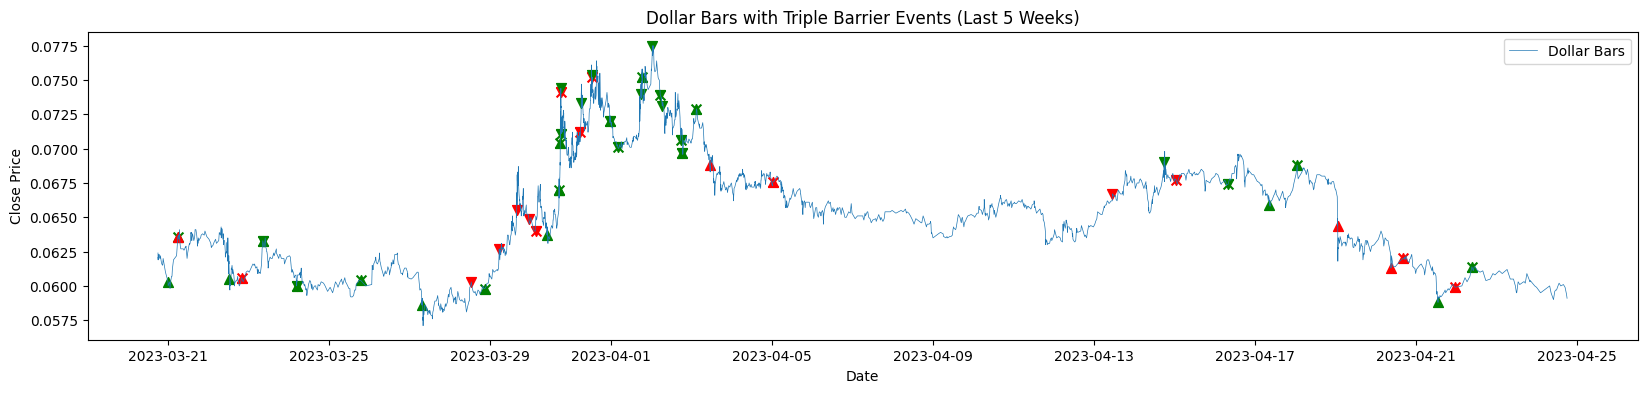

In [66]:
offset = 5
# Filter the dollar bars for the last few weeks, defined by offset
last_week = dollar_bars['datetime'].iloc[-1] - pd.DateOffset(weeks=offset)
dollar_bars_last_week = dollar_bars[dollar_bars['datetime'] > last_week]

tblw = triple_barrier_labels['datetime'].iloc[-1] - pd.DateOffset(weeks=offset)
tblw = triple_barrier_labels[triple_barrier_labels['datetime'] > tblw]

fig, ax = plt.subplots(figsize=(20, 4))

# Plot the dollar bars for the last week
sns.lineplot(ax=ax, x=dollar_bars_last_week['datetime'], y=dollar_bars_last_week['close'], label='Dollar Bars', linewidth=0.5)

triple_barrier_labels_last_week = triple_barrier_labels[triple_barrier_labels['datetime'] > last_week]

for _, row in triple_barrier_labels_last_week.iterrows():
    start_time = row['datetime']
    end_time = row['t1']
    start_price = dollar_bars[dollar_bars['datetime'] == start_time]['close'].values[0]
    end_price = dollar_bars[dollar_bars['datetime'] == end_time]['close'].values[0]

    if row['return'] > 0:
        color = 'green'
    else:
        color = 'red'

    if row['side'] == 1:  # Long trade
        start_marker = '^'
    else:  # Short trade
        start_marker = 'v'

    ax.scatter([start_time, end_time], [start_price, end_price], marker=start_marker, color=color, s=50)
    ax.scatter(end_time, end_price, marker='x', color=color, s=50)

# Update layout
ax.set(title=f'Dollar Bars with Triple Barrier Events (Last {offset} Weeks)', xlabel='Date', ylabel='Close Price')
ax.legend()

# Display the plot
plt.show()


Summary of results from the entire trading period:

In [65]:
accuracy = triple_barrier_labels['return'].gt(0).mean()
average_trade_return = triple_barrier_labels['return'].mean()
print('Trade Accuracy: {:.3f}%'.format(accuracy*100))
print('Average Trade Return: {:.3f}%'.format(average_trade_return*100))

Trade Accuracy: 67.314%
Average Trade Return: 1.407%


**Nice 🎉**

In this notebook, we've successfully built a primary model for finance trading using data processing techniques, without little need for machine learning. 

We've demonstrated the advantages of using **dollar bars** over tick data, as well as other methods for enhancing the reliability of our trading signals.

We've introduced the **CUSUM** filter for detecting significant events, and implemented the **triple barrier method** to better manage our trades with profit taking, stop loss, and time barriers. 

These functions are often found behind paywalls.

_Feel free to use the methods presented in this notebook for your own trading strategies._

Next, we will focus on improving the accuracy of the primary model with feature engineering, train-test-val splits to minimize data leakage and secondary models (machine learning)